In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = "/content/drive/My Drive/UnorganizedDataset"  # Path to the dataset
output_dir = "output_data"  # Path to the split dataset

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio):
    # Loop through each class
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory files

        # Collect all image paths
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        if len(images) < 3:  # Ensure minimum images for splitting
            print(f"Skipping '{class_name}' (not enough images for splitting).")
            continue

        # Perform the split
        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

        # Create and populate train, val, test directories
        for split, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_path in split_images:
                shutil.copy(img_path, split_dir)

# Call the function
split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio)

print("Dataset has been successfully split into train, val, and test!")


Dataset has been successfully split into train, val, and test!


In [3]:
# Paths
train_dir = "output_data/train"
val_dir = "output_data/val"
test_dir = "output_data/test"

# Parameters
img_size = (224, 224)  # Standard for MobileNetV2
batch_size = 32
epochs = 10
learning_rate = 0.00001

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

# Load MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
learning_rate = 0.00001  # Lower learning rate for fine-tuning
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1,
)

# Save the trained model
model.save("coconut_MobileNetV2_model.h5")

# Test the model (optional)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)


Found 2712 images belonging to 4 classes.
Found 582 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 770s 9s/step - accuracy: 0.3633 - loss: 1.5140 - val_accuracy: 0.5533 - val_loss: 1.0318
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 740s 9s/step - accuracy: 0.6916 - loss: 0.8019 - val_accuracy: 0.7027 - val_loss: 0.7170
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 751s 9s/step - accuracy: 0.8576 - loss: 0.4666 - val_accuracy: 0.7852 - val_loss: 0.5276
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 804s 9s/step - accuracy: 0.9179 - loss: 0.2944 - val_accuracy: 0.8385 - val_loss: 0.3965
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 745s 9s/step - accuracy: 0.9466 - loss: 0.1956 - val_accuracy: 0.8797 - val_loss: 0.3119
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 731s 9s/step - accuracy: 0.9495 - loss: 0.1724 - val_accuracy: 0.9107 - val_loss: 0.2486
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 744s 9s/step - accuracy: 0.9605 - loss: 0.1397 - val_accuracy: 0.9227 - val_loss: 0.2050
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 741s 9s/step - accuracy: 0.9750 - loss: 0.0974 - val_accuracy: 0.9399 - val_loss: 0.

Found 584 images belonging to 4 classes.


In [4]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9466 - loss: 0.1165
Validation Accuracy: 95.36%
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9797 - loss: 0.0813
Test Accuracy: 97.26%


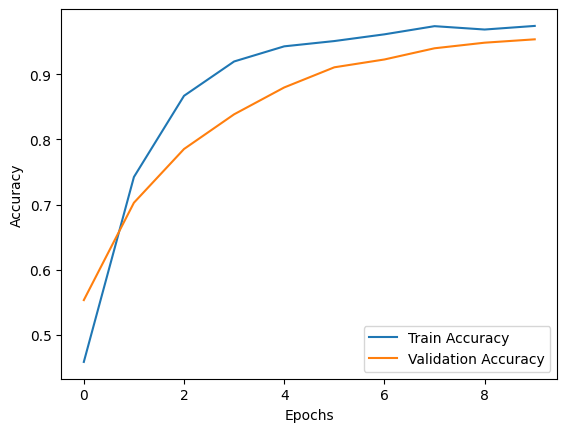

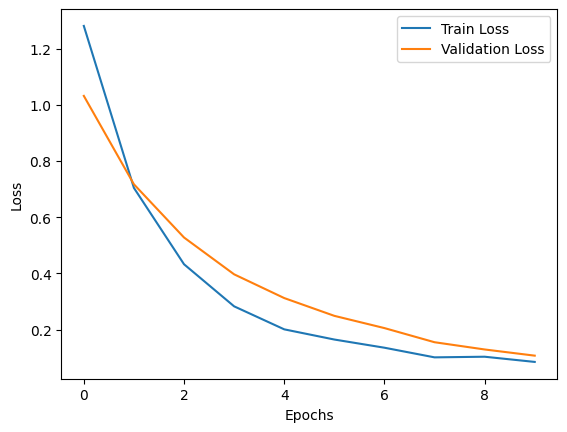

In [5]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
Confusion Matrix:
[[29 34 43 34]
 [24 20 38 32]
 [40 27 57 54]
 [37 28 43 44]]
Classification Report:
              precision    recall  f1-score   support

      Mature       0.22      0.21      0.21       140
  NonCoconut       0.18      0.18      0.18       114
         Old       0.31      0.32      0.32       178
       Young       0.27      0.29      0.28       152

    accuracy                           0.26       584
   macro avg       0.25      0.25      0.25       584
weighted avg       0.26      0.26      0.26       584



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


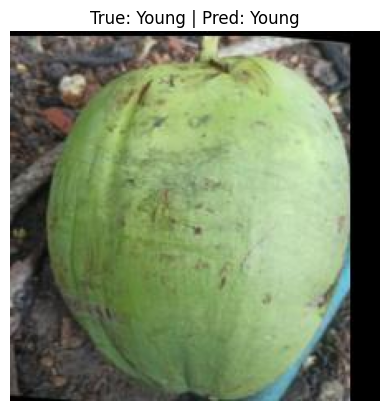

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


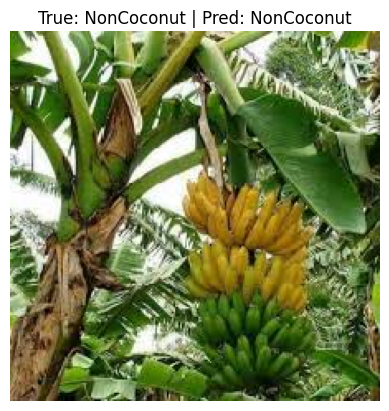

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


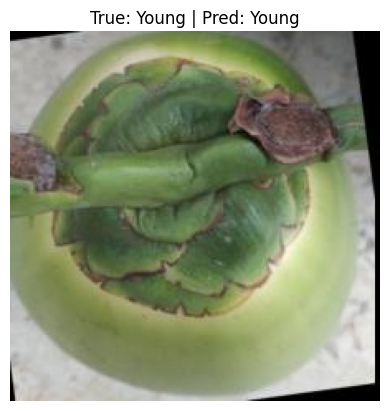

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


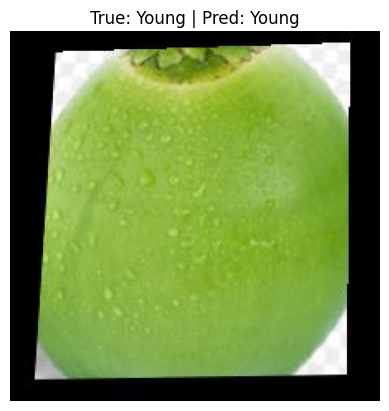

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


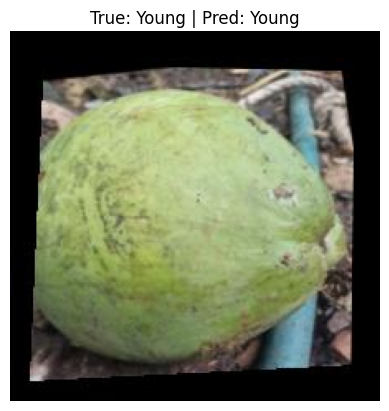

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


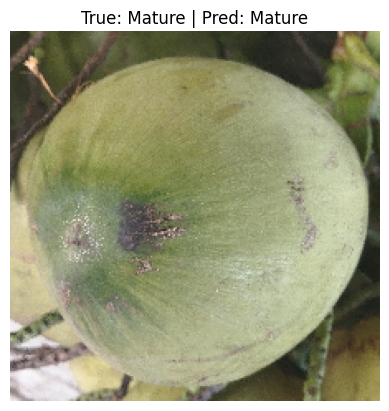

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


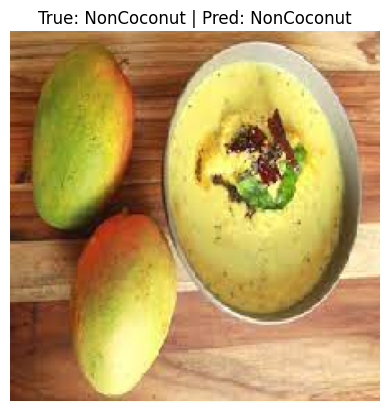

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


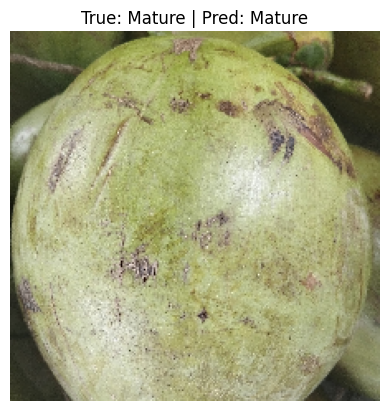

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


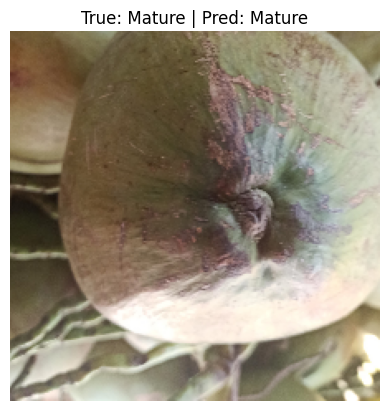

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


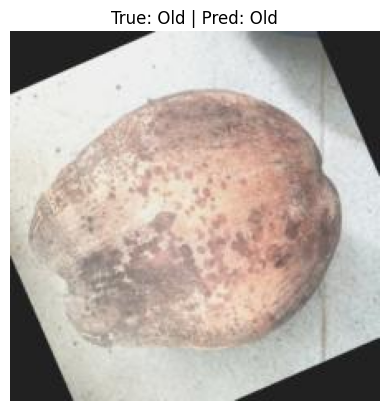

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Iterate over the test generator
for i, (img, label) in enumerate(test_generator):  # Unpack batches from the generator
    if i >= 10:  # Show only the first 10 test images
        break

    # Predict the class
    pred = model.predict(img)
    pred_label = class_labels[np.argmax(pred[0])]
    true_label = class_labels[np.argmax(label[0])]

    # Display the image
    plt.imshow(img[0])
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()
